<a href="https://colab.research.google.com/github/outofray/3D_Unet_CT/blob/main/3D_Unet_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Conv3D, MaxPooling3D, Conv3DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import skimage.io as io
from glob import glob
import pandas as pd
import nibabel as nib
import numpy as np
import random as r
import cv2



In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install simpleitk

     |████████████████████████████████| 48.4 MB 31 kB/s 


In [ ]:
import SimpleITK as sitk

In [ ]:
def clamp_HU(image,MIN_BOUND = -1000,MAX_BOUND = 400.0):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image

# Load file

In [ ]:
# 顯示影像切面
def myShowImage(image, z_index):
    nda = sitk.GetArrayViewFromImage(image)
    slice = nda[z_index,:,:]
    plt.imshow(slice)
    plt.show()

In [ ]:
file_path = 'gdrive/MyDrive/AI_CT/ischemic_bowel_Abdomen.nii.gz'

image = sitk.ReadImage(file_path)
print("Size:", image.GetSize())
print("Origin:", image.GetOrigin())
print("Spacing", image.GetSpacing())

Size: (512, 512, 96)
Origin: (-189.15789794921875, 302.31640625, -802.699951171875)
Spacing (0.68359375, 0.68359375, 5.0)


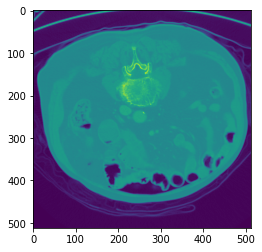

In [ ]:
# 顯示影像切面
myShowImage(image, 48)

In [ ]:
image_small = sitk.Shrink(image, [4, 4, 1])

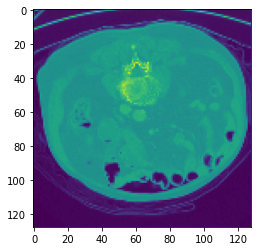

In [ ]:
myShowImage(image_small, 48)

## Visualize CT Image

Text(0.5, 1.0, 'axial (transverse) plane')

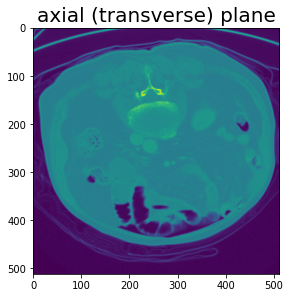

In [ ]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(first_img[50,:,:])
plt.title("axial (transverse) plane", fontsize=20)


## Visualize Segmented Image

In [ ]:
seg_img = io.imread('gdrive/MyDrive/AI_CT/ischemic_bowel_Abdomen_label.nii.gz', plugin="simpleitk")

print(f"shape: {seg_img.shape}")
print(f"dtype: {seg_img.dtype}")

shape: (96, 512, 512)
dtype: float64


Text(0.5, 1.0, 'segmentation for axial (transverse) plane')

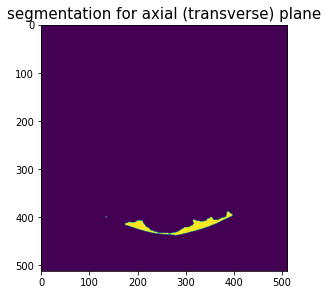

In [ ]:
fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(seg_img[50,:,:])
plt.title("segmentation for axial (transverse) plane", fontsize=15)

# Convert CT image to Array 

In [ ]:
def to_array(path, end, z_slice_number=4):
    
    # get locations
    files = glob(path+end, recursive=True)
    
    img_list = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        img = sitk.ReadImage(file)
        # img= sitk.Shrink(img, [1, 1, 1])
        # to numpy array
        img = sitk.GetArrayFromImage(img)
        # standardization
        img = (img-img.mean())/img.std()
        img.astype("float32")
        
        for slice in range(0, img.shape[0], z_slice_number):

          if slice+z_slice_number+1 < img.shape[0]:
            img_s = img[slice:slice+z_slice_number,:,:]
            img_s = np.expand_dims(img_s, axis=0)
            img_list.append(img_s)
          else:
            break
            
    return np.array(img_list, np.float32)

In [ ]:
def read_dataset(csv_file, folder, dataset):
  df = pd.read_csv(csv_file)
  df = df[df["Train/valid/test"]==dataset]
  dataset_ID = df['ACCID'].squeeze().tolist()

  arr = np.empty((0,1,16,512,512))
  for ID in dataset_ID:
    path = folder+ID
    if "LABEL" in path:
      data = seg_to_array(path=path, z_slice_number=16, end="_label.nii.gz")
    data = to_array(path=path, z_slice_number=16, end=".nii.gz")
    arr = np.append(data, arr, axis=0)

  return arr

In [ ]:
# read image to array
csv_file = "/content/gdrive/MyDrive/AI_CT/Pneumoperitoneum_310/6_pneumoperitoneum_list_1_allP_310.csv"
folder = "/content/gdrive/MyDrive/AI_CT/Pneumoperitoneum_310/Pneumoperitoneum_image/"
dataset = 1 #train=1, val=2, test=3

train = read_dataset(csv_file, folder, dataset)

In [ ]:
np.save("/content/gdrive/MyDrive/AI_CT/Pneumoperitoneum_310/train.npy", train)

(111, 1, 16, 512, 512)


In [ ]:
train = np.load("/content/gdrive/MyDrive/AI_CT/Pneumoperitoneum_310/train.npy")
train.shape

(111, 1, 16, 512, 512)

# Convert Segmented Images To Array

In [ ]:
def seg_to_array(path, end, label, z_slice_number=4):
    
    # get locations
    files = glob(path+end, recursive=True)
    
    img_list = []
    
    r.seed(42)
    r.shuffle(files)
    
    for file in files:
        img = sitk.ReadImage(file)
        img= sitk.Shrink(img, [1, 1, 1])
        # to numpy array
        img = sitk.GetArrayFromImage(img)

        # pneumoperitoneum as label 1, keep if statement for future target
        if label == 1:
            img[img == 1]
            

        img.astype("float32")
        
        for slice in range(0, img.shape[0], z_slice_number):
          if slice+z_slice_number+1<img.shape[0]:

            img_s = img[slice:slice+z_slice_number,:,:]
            
            img_s = np.expand_dims(img_s, axis=0)
            img_list.append(img_s)
          else:
            break
            
    return np.array(img_list,np.float32)

In [ ]:
folder = "/content/gdrive/MyDrive/AI_CT/Pneumoperitoneum_310/Pneumoperitoneum_LABEL/"
train_seg = np.empty((0,1,16,512,512), float)
for ACCID in train_ACCID[:20]:
  path = folder+ACCID
  train_seg_data = to_array(path=path, z_slice_number=16, end="_label.nii.gz")
  # if train_seg_data.shape[4] != 512:
  #   continue
  # print(train_seg_data.shape)
  train_seg = np.append(train_seg_data, train_seg, axis=0)
  # print(train_seg.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
print(train_seg.shape)
np.save("/content/gdrive/MyDrive/AI_CT/Pneumoperitoneum_310/train_seg.npy", train_seg)

(111, 1, 16, 512, 512)


In [ ]:
train_seg = np.load("/content/gdrive/MyDrive/AI_CT/Pneumoperitoneum_310/train_seg.npy")

In [ ]:
new_train_seg = arr_4

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/AI_CT/Pneumoperitoneum_310/6_pneumoperitoneum_list_1_allP_310.csv")
df_val = df[df["Train/valid/test"]==2]
val_ACCID = df_val['ACCID'].squeeze().tolist()
val_ACCID

In [ ]:
folder = "/content/gdrive/MyDrive/AI_CT/Pneumoperitoneum_310/Pneumoperitoneum_image/"
val = np.empty((0,1,16,64,64), float)
for ACCID in val_ACCID:
  path = folder+ACCID
  val_data = to_array(path=path, z_slice_number=16, end=".nii.gz")
  if val_data.shape[4] != 64:
    continue
  # print(val_data.shape)
  val = np.append(val_data, val, axis=0)
  # print(val.shape)

In [ ]:
print(val.shape)
np.save("/content/gdrive/MyDrive/AI_CT/Pneumoperitoneum_310/val_64.npy", val)

(345, 1, 16, 64, 64)


In [ ]:
val = np.load("/content/gdrive/MyDrive/AI_CT/Pneumoperitoneum_310/val.npy")

In [ ]:
folder = "/content/gdrive/MyDrive/AI_CT/Pneumoperitoneum_310/Pneumoperitoneum_LABEL/"
val_seg = np.empty((0,1,16,64,64), float)
for ACCID in val_ACCID:
  path = folder+ACCID
  val_seg_data = to_array(path=path, z_slice_number=16, end="_label.nii.gz")
  if val_seg_data.shape[4] != 64:
    continue
  # print(val_seg_data.shape)
  val_seg = np.append(val_seg_data, val_seg, axis=0)
  # print(val_seg.shape)

In [ ]:
print(val_seg.shape)
np.save("/content/gdrive/MyDrive/AI_CT/Pneumoperitoneum_310/val_seg_64.npy", val_seg)

(345, 1, 16, 64, 64)


In [ ]:
val_seg=np.load("/content/gdrive/MyDrive/AI_CT/Pneumoperitoneum_310/val_seg.npy")

In [ ]:
new_train = arr_4

In [ ]:
def Split_Array(array, num_split):
  array_3 = np.split(array, num_split, axis=3) #Array, num of splits, axis for splitting
  arr_3 = np.empty((0,1,16,512/num_split,512))
  for i in range(num_split):
    arr_3 = np.append(array_3[i], arr_3, axis=0)

  array_4 = np.split(arr_3, 16, axis=4)
  arr_4 = np.empty((0,1,16,512/num_split,512/num_split))
  for i in range(num_split):
    arr_4 = np.append(array_4[i], arr_4, axis=0)

  return arr_4

# 3D U-NET MODEL

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    

K.set_image_data_format('channels_first')


def unet():
    
    inputs = Input((1, 16, 32, 32))
    
    conv1 = Conv3D(64, (3, 3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv3D(64, (3, 3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling3D((2, 2, 2), padding='same')(batch1)

    conv2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling3D((2, 2, 2), padding='same')(batch2)

    conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling3D((2, 2, 2), padding='same')(batch3)

    conv4 = Conv3D(512, (3, 3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv3D(512, (3, 3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2), padding='same')(batch4)

    conv5 = Conv3D(1024, (3, 3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv3D(1024, (3, 3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)

    up6 = Conv3DTranspose(512, (2, 2, 2), strides=(2, 2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv3D(512, (3, 3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv3D(512, (3, 3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv3D(256, (3, 3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv3D(256, (3, 3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv3D(128, (3, 3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv3D(128, (3, 3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv3D(64, (3, 3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv3D(64, (3, 3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [ ]:
model = unet()

model.summary()

#Training

In [ ]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

loss_history = LossHistory()

In [ ]:
checkpoint_filepath = "/content/drive/MyDrive/AI_CT/best_model_32.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, 
    save_best_only=True, 
    monitor='val_loss', #based on best val_loss
    mode='auto', verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,                                                  
                                              patience=10, min_lr=1e-8)

callbacks = [model_checkpoint, reduce_lr, loss_history]

In [ ]:
history = model.fit(new_train, new_train_seg, validation_split=0.25, batch_size=16, epochs=20, shuffle=True, callbacks=callbacks)

Epoch 1/20
1332/1332 [==============================] - ETA: 0s - loss: -0.0798 - dice_coef: 1.0798

In [ ]:
# plot train/validation dice_coef
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model Dice')
plt.ylabel('Dice')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# plot train/validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Va.'], loc='upper left')
plt.show()

In [ ]:
model.save_weights("/content/drive/MyDrive/AI_CT/best_model.hdf5")

# PREDICTION for 2D U-Net

In [ ]:
model.load_weights("/content/drive/MyDrive/AI_CT/best_model_32.hdf5")

In [ ]:
i=200

In [ ]:
for j in range(16):
  fig=plt.figure(figsize=(9,9))

  plt.subplot(1,3,1)   
  plt.imshow(new_train[i][0][j]);

  plt.subplot(1,3,2) 
  plt.imshow(new_train_seg[i][0][j]);

  expand_img = np.expand_dims(train[i], axis=0)
  pred = model.predict(expand_img)
  super_threshold_indices = pred < 0.99
  pred[super_threshold_indices] = 0

  plt.subplot(1,3,3) 
  plt.imshow(pred[0][0][j]);

  plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


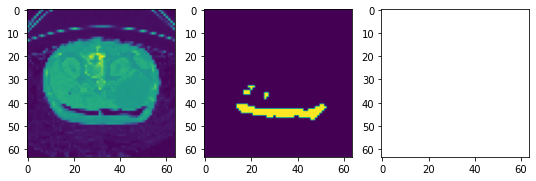

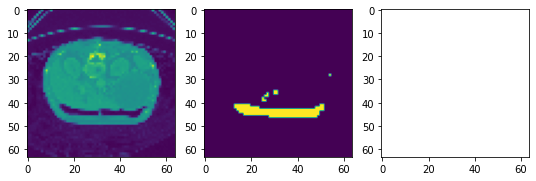

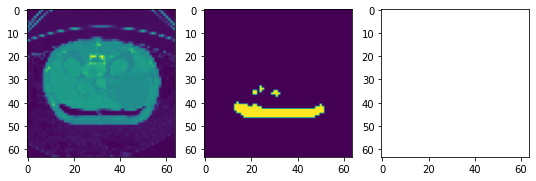

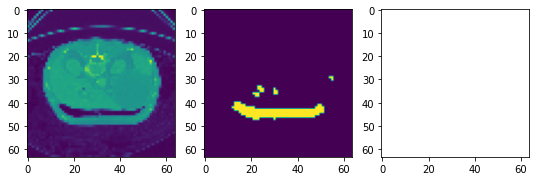

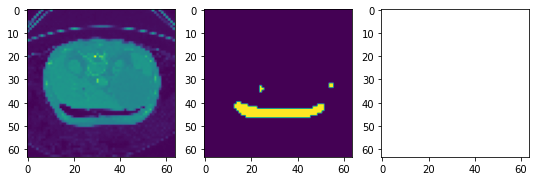

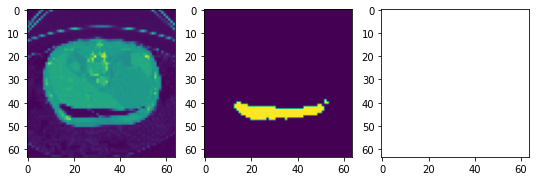

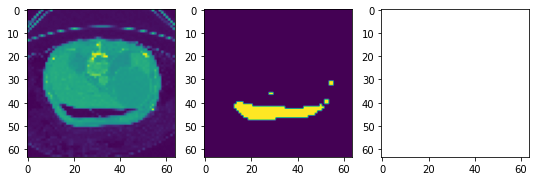

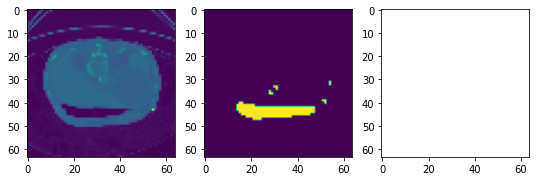

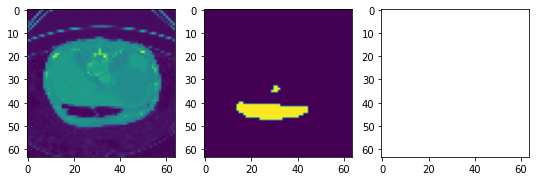

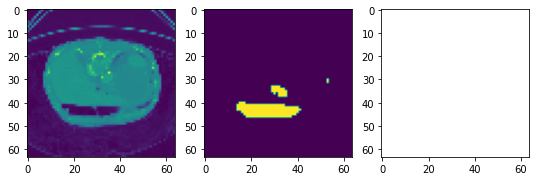

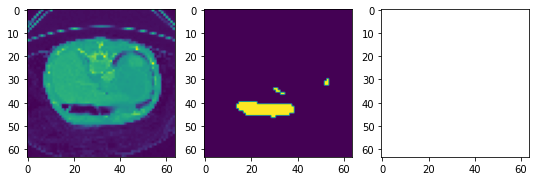

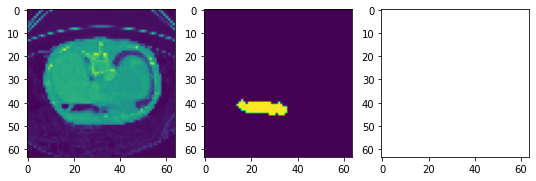

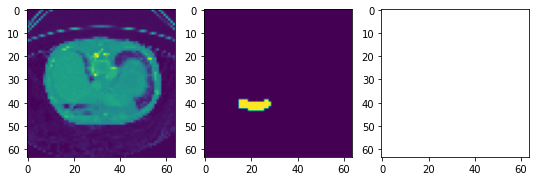

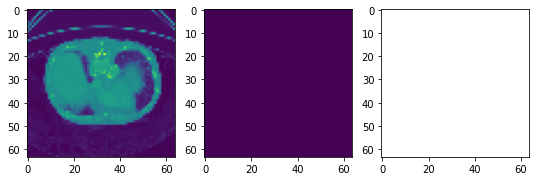

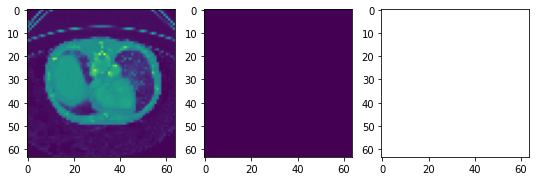

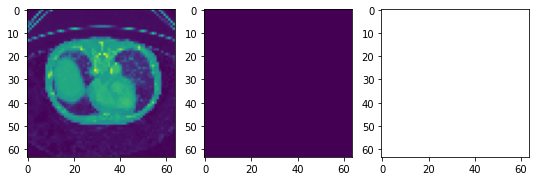

In [ ]:
for j in range(16):
  fig=plt.figure(figsize=(9,9))

  plt.subplot(1,3,1)   
  plt.imshow(val[i][0][j]);

  plt.subplot(1,3,2) 
  plt.imshow(val_seg[i][0][j]);

  expand_img = np.expand_dims(val[i], axis=0)
  pred = model.predict(expand_img)
  super_threshold_indices = pred < 0.99
  pred[super_threshold_indices] = 0

  plt.subplot(1,3,3) 
  plt.imshow(pred[0][0][j]);

  plt.show()